#### use the simple Gaussian wavefunction ansatz on VMC, with used def step(self, n_cfg=400, lr=1e-4, clip=100.0):

00  E =  2033.662  α = 0.0495
01  E =  2083.955  α = 0.0490
02  E =  1266.076  α = 0.0485
03  E =  1351.474  α = 0.0480
04  E =  1325.819  α = 0.0476
05  E =  2479.093  α = 0.0471
06  E =  1491.969  α = 0.0466
07  E =  2069.800  α = 0.0462
08  E =  1189.233  α = 0.0457
09  E =  1456.776  α = 0.0452
10  E =  2076.909  α = 0.0448
11  E =   579.758  α = 0.0443
12  E =  1695.553  α = 0.0439
13  E =  1799.590  α = 0.0435
14  E =  1692.081  α = 0.0430
15  E =  1538.437  α = 0.0426
16  E =  1806.903  α = 0.0422
17  E =  1909.577  α = 0.0418
18  E =  1679.249  α = 0.0413
19  E =  1756.444  α = 0.0409
20  E =  1923.182  α = 0.0405
21  E =  1714.253  α = 0.0401
22  E =  1443.024  α = 0.0397
23  E =  1217.929  α = 0.0393
24  E =  1848.728  α = 0.0389
25  E =  1341.660  α = 0.0386
26  E =  1578.243  α = 0.0382
27  E =   490.617  α = 0.0378
28  E =  1987.746  α = 0.0374
29  E =  1335.185  α = 0.0370
30  E =  1681.834  α = 0.0367
31  E =  1542.825  α = 0.0363
32  E =  1012.888  α = 0.0359
33  E =   

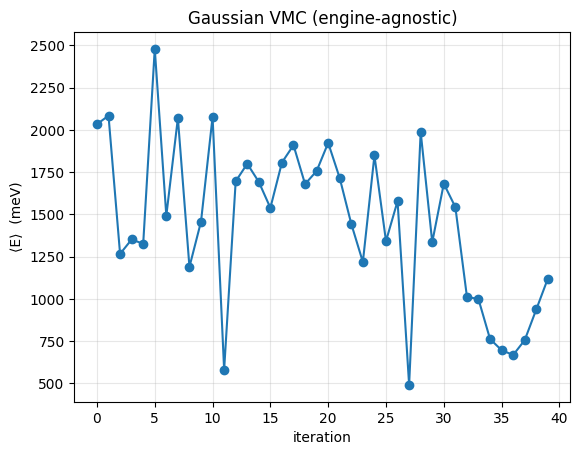

In [1]:
import numpy as np, matplotlib.pyplot as plt
from moire_model import energy_static, a_m
from vmc_core    import VMC
from wf_gaussian import GaussianWF

np.random.seed(0)
wf  = GaussianWF(N_e=6, alpha0=0.05)
vmc = VMC(wf, energy_static, box_length=a_m)

E_curve=[]
for it in range(40):
    E, grad, pars = vmc.step(n_cfg=600, lr=1e-4)
    print(f"{it:02d}  E = {E:9.3f}  α = {np.exp(pars[0]):.4f}")
    E_curve.append(E)

plt.plot(E_curve, marker="o"); plt.grid(alpha=.3)
plt.ylabel("⟨E⟩  (meV)"); plt.xlabel("iteration")
plt.title("Gaussian VMC (engine-agnostic)")
plt.show()

#### Test on Gaussian with def step(self, n_cfg=2000, lr=1e-5, clip=100.0):

00  E =  2033.662  α = 0.0495
01  E =  2083.955  α = 0.0490
02  E =  1266.076  α = 0.0485
03  E =  1351.474  α = 0.0480
04  E =  1325.819  α = 0.0476
05  E =  2479.093  α = 0.0471
06  E =  1491.969  α = 0.0466
07  E =  2069.800  α = 0.0462
08  E =  1189.233  α = 0.0457
09  E =  1456.776  α = 0.0452
10  E =  2076.909  α = 0.0448
11  E =   579.758  α = 0.0443
12  E =  1695.553  α = 0.0439
13  E =  1799.590  α = 0.0435
14  E =  1692.081  α = 0.0430
15  E =  1538.437  α = 0.0426
16  E =  1806.903  α = 0.0422
17  E =  1909.577  α = 0.0418
18  E =  1679.249  α = 0.0413
19  E =  1756.444  α = 0.0409
20  E =  1923.182  α = 0.0405
21  E =  1714.253  α = 0.0401
22  E =  1443.024  α = 0.0397
23  E =  1217.929  α = 0.0393
24  E =  1848.728  α = 0.0389
25  E =  1341.660  α = 0.0386
26  E =  1578.243  α = 0.0382
27  E =   490.617  α = 0.0378
28  E =  1987.746  α = 0.0374
29  E =  1335.185  α = 0.0370
30  E =  1681.834  α = 0.0367
31  E =  1542.825  α = 0.0363
32  E =  1012.888  α = 0.0359
33  E =   

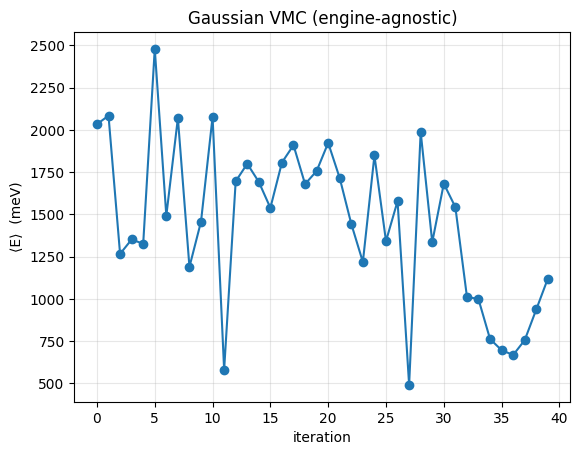

In [3]:
import numpy as np, matplotlib.pyplot as plt
from moire_model import energy_static, a_m
from vmc_core    import VMC
from wf_gaussian import GaussianWF

np.random.seed(0)

wf  = GaussianWF(N_e=6, alpha0=0.05)
vmc = VMC(wf, energy_static, box_length=a_m)

E_curve=[]
for it in range(40):
    E, grad, pars = vmc.step(n_cfg=600, lr=1e-4)
    print(f"{it:02d}  E = {E:9.3f}  α = {np.exp(pars[0]):.4f}")
    E_curve.append(E)

plt.plot(E_curve, marker="o"); plt.grid(alpha=.3)
plt.ylabel("⟨E⟩  (meV)"); plt.xlabel("iteration")
plt.title("Gaussian VMC (engine-agnostic)")
plt.show()

#### test on the Plain Slater ansatz on VMC (no optimisation since no parameters yet):

00  ⟨E⟩ = -6983.404  meV
01  ⟨E⟩ = -7232.282  meV
02  ⟨E⟩ = -15194.972  meV
03  ⟨E⟩ = -2563.171  meV
04  ⟨E⟩ = -4247.488  meV
05  ⟨E⟩ =  -369.319  meV
06  ⟨E⟩ = -13624.137  meV
07  ⟨E⟩ = -14881.117  meV
08  ⟨E⟩ = -8445.251  meV
09  ⟨E⟩ = -21567.234  meV
10  ⟨E⟩ =   173.942  meV
11  ⟨E⟩ = -3445.811  meV
12  ⟨E⟩ = -13927.158  meV
13  ⟨E⟩ =  -120.414  meV
14  ⟨E⟩ = -3928.855  meV
15  ⟨E⟩ = -15484.893  meV
16  ⟨E⟩ = -1860.182  meV
17  ⟨E⟩ = -4856.817  meV
18  ⟨E⟩ = -15955.064  meV
19  ⟨E⟩ = -2864.225  meV
20  ⟨E⟩ = -1288.186  meV
21  ⟨E⟩ = -3018.204  meV
22  ⟨E⟩ = -24375.343  meV
23  ⟨E⟩ = -6110.594  meV
24  ⟨E⟩ = -24210.841  meV
25  ⟨E⟩ = -7728.462  meV
26  ⟨E⟩ = -13640.705  meV
27  ⟨E⟩ = -1672.101  meV
28  ⟨E⟩ =  -959.355  meV
29  ⟨E⟩ = -12785.425  meV


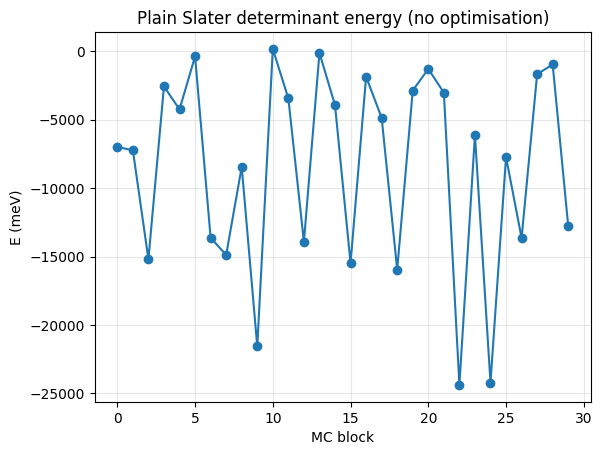

In [18]:
import numpy as np, matplotlib.pyplot as plt
from moire_model import energy_static, a_m
from vmc_core    import VMC
from wf_slater   import SlaterWF

# ---- choose a simple “Fermi sea” of 6 plane-waves ---------------------
k_mag = 2*np.pi/a_m
k_vectors = k_mag * np.array([[0,0], [1,0], [-1,0], [0,1], [0,-1], [1,1]])  # toy choice

wf  = SlaterWF(k_vectors, L=a_m)
vmc = VMC(wf, energy_static, box_length=a_m)

E_trace=[]
for it in range(30):
    E, grad, _ = vmc.step(n_cfg=800, lr=0.0)   # lr=0 ⇒ just evaluate
    print(f"{it:02d}  ⟨E⟩ = {E:9.3f}  meV")
    E_trace.append(E)

plt.plot(E_trace, marker="o")
plt.grid(alpha=.3); plt.xlabel("MC block"); plt.ylabel("E (meV)")
plt.title("Plain Slater determinant energy (no optimisation)")
plt.show()

#### Run VMC with Bloch determinant: here we Replace cosine orbitals by Bloch eigenfunctions (recall, from dispersion relation), and we choose correct k vectors (from hexagonal Fermi sea)

In [27]:
from vmc_core    import VMC
from moire_model import energy_static, a_m
from wf_bloch_slater import BlochSlaterWF
import pickle, numpy as np

bloch_table = pickle.load(open("bloch_coeffs.pkl","rb"))
wf  = BlochSlaterWF(bloch_table, L=a_m)
vmc = VMC(wf, energy_static, box_length=a_m)

# ---- run the VMC engine -----------------------------------------------
for it in range(30):
    E,_,_ = vmc.step(n_cfg=1000, lr=0.0)   # evaluate only
    print(it, E)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


0 -59862.18069547336
1 -18456.76767826332
2 -25056.827395675053
3 -32228.815984050263
4 -7135.786583928658
5 -14326.84451250749
6 -28280.029996318826
7 -15397.271290927029
8 -52139.78112874459
9 -13517.915761636235
10 -39401.70930339028
11 -13036.708065889023
12 -29126.167492639222
13 -30602.462100879704
14 -8048.857744311873
15 -34220.11994118332
16 -18209.596972113002
17 -10130.161366905519
18 -20024.79082002335
19 -20717.73714413233
20 -31822.59713026902
21 -33026.86283648704
22 -24397.557065408815
23 -17908.556051839554
24 -27549.15261928286
25 -24599.13739172215
26 -35110.61010779954
27 -9394.536711644256
28 -16709.2792054011
29 -12062.252492229884


In [ ]:
import numpy as np, matplotlib.pyplot as plt, torch
from moire_model   import energy_static, a_m
from vmc_core      import VMC
from wf_slaternet import SlaterNetWF

00  ⟨E⟩ = 11140.912 meV   |grad|=1.01e+04
01  ⟨E⟩ =  7597.656 meV   |grad|=1.27e+04
02  ⟨E⟩ = 10863.738 meV   |grad|=1.15e+04
03  ⟨E⟩ = 11280.579 meV   |grad|=1.15e+04
04  ⟨E⟩ =  9841.960 meV   |grad|=1.24e+04
05  ⟨E⟩ = 11175.181 meV   |grad|=1.02e+04
06  ⟨E⟩ =  8490.960 meV   |grad|=1.31e+04
07  ⟨E⟩ = 10005.797 meV   |grad|=1.22e+04
08  ⟨E⟩ =  9794.444 meV   |grad|=1.20e+04
09  ⟨E⟩ =  8984.520 meV   |grad|=1.27e+04
10  ⟨E⟩ =  9152.890 meV   |grad|=1.22e+04
11  ⟨E⟩ = 10798.179 meV   |grad|=1.04e+04
12  ⟨E⟩ = 10354.986 meV   |grad|=1.18e+04
13  ⟨E⟩ = 10261.113 meV   |grad|=1.20e+04
14  ⟨E⟩ = 10066.454 meV   |grad|=1.17e+04
15  ⟨E⟩ = 11070.819 meV   |grad|=1.28e+04
16  ⟨E⟩ = 10312.221 meV   |grad|=9.97e+03
17  ⟨E⟩ = 11682.675 meV   |grad|=1.07e+04
18  ⟨E⟩ = 10870.060 meV   |grad|=1.14e+04
19  ⟨E⟩ = 11544.028 meV   |grad|=1.07e+04
20  ⟨E⟩ =  9465.437 meV   |grad|=1.31e+04
21  ⟨E⟩ = 10301.762 meV   |grad|=1.05e+04
22  ⟨E⟩ =  8396.383 meV   |grad|=1.32e+04
23  ⟨E⟩ = 10417.326 meV   |grad|=9

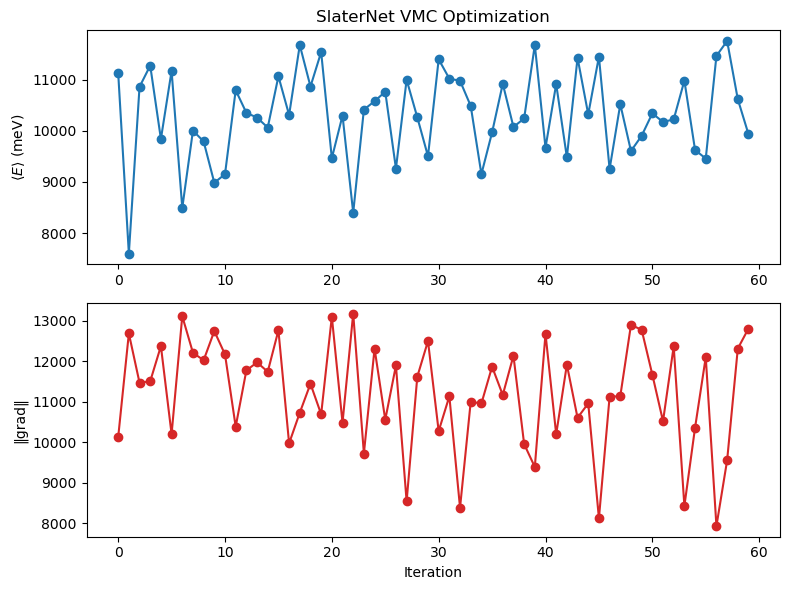

In [7]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

N_e = 6
wf  = SlaterNetWF(N_e, n_hidden=64, n_layer=4, L=a_m, device="cpu")
vmc = VMC(wf, energy_static, box_length=a_m)

E_trace       = []
grad_norms    = []

for it in range(60):
    E, grad, _ = vmc.step(n_cfg=1500, lr=5e-4)
    E_trace.append(E)
    grad_norms.append(np.linalg.norm(grad))
    print(f"{it:02d}  ⟨E⟩ = {E:9.3f} meV   |grad|={grad_norms[-1]:.2e}")

# now plot
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(E_trace,   marker='o')
plt.ylabel(r"$\langle E\rangle$ (meV)")
plt.title("SlaterNet VMC Optimization")

plt.subplot(2,1,2)
plt.plot(grad_norms, marker='o', color='C3')
plt.ylabel("‖grad‖")
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()
